In [1]:
# pour une première approche on peut se passer de ça
using Pkg
Pkg.activate(".")   # load the specific environment from Project.toml
Pkg.instantiate()   # download the required package if necessary

using CairoMakie    # for plotting, Plots is an alternative


  Activating project at `~/ownCloud/Programmes/julia/EDO_mam3/EDO_polytec`


# Problème de Cauchy

Nous allons approximer la solution de l'EDO 
$$
\dot x = r x, 
$$
depuis $x(0)=x_0$ via la méthode d'Euler

In [2]:
# time parameters
t0 = 0.0
tf = 5.0
h = 0.01

# range from t0 to tf every h
tspan = t0:h:tf


0.0:0.01:5.0

In [3]:
# EDO parameter
r = 1.0


1.0

In [4]:
# initial condition
x0 = 1.0


1.0

## version script

### version avec `push`

In [38]:
sol_euler = [x0]  # initiate the solution as a vector

for i in tspan[2:end]   # the component at tspan[1] = t0 is actually x0
    solnext = sol_euler[end] + r * h * sol_euler[end]   # compute next approx
    push!(sol_euler, solnext)                     # push it into sol
end


In [39]:
# quick look on the computation
sol_euler[1:3]


3-element Vector{Float64}:
 1.0
 1.01
 1.0201

#### basic plot

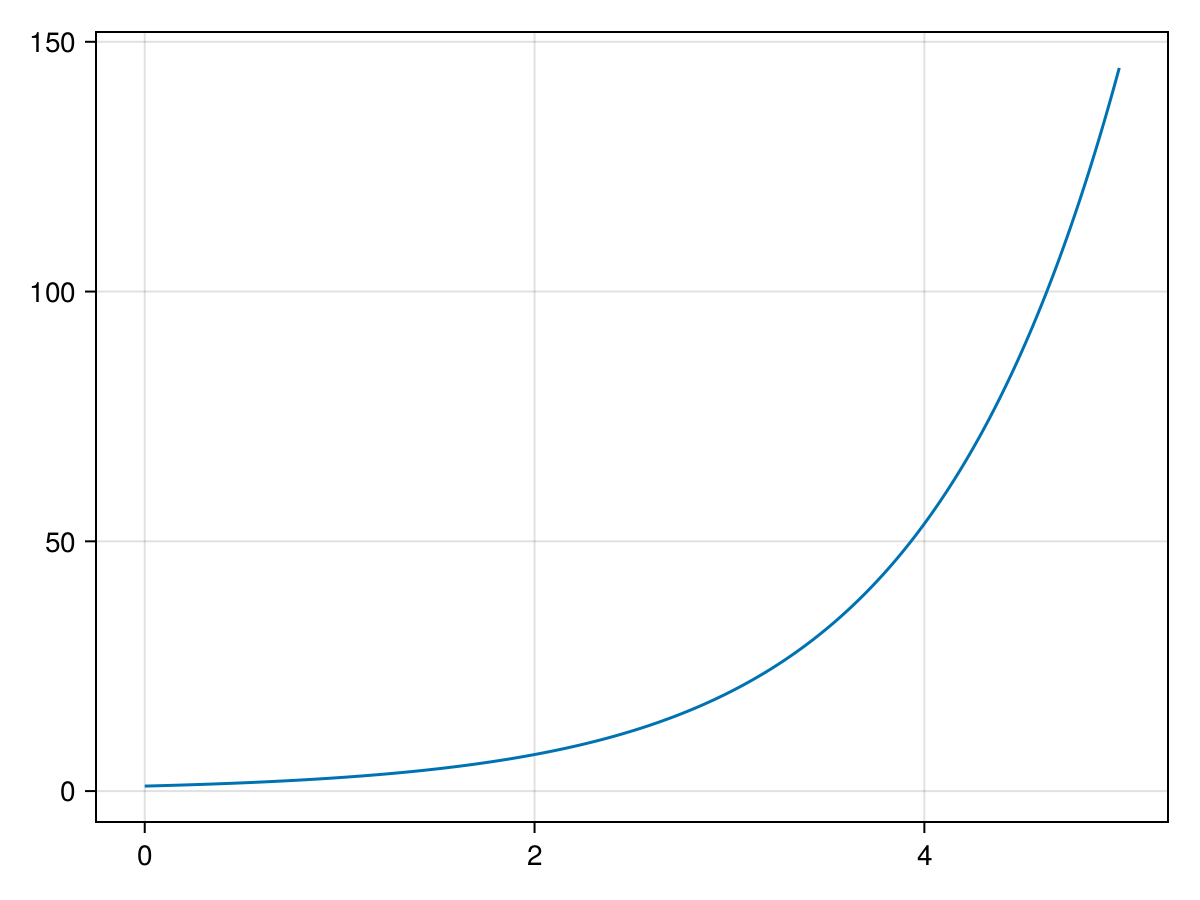

In [40]:
lines(tspan, sol_euler)


#### advanced plot

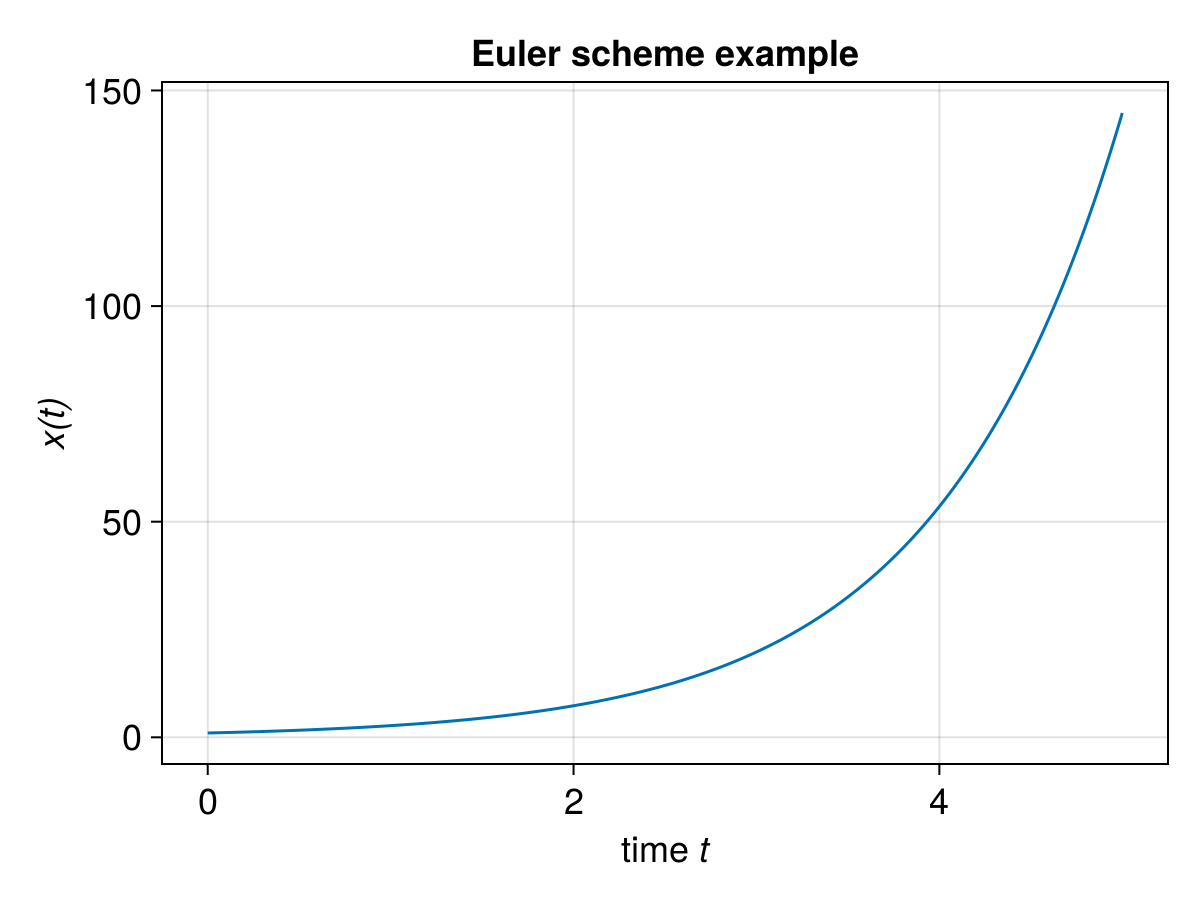

In [59]:
fig = Figure(; fontsize = 18)       # ; is optional, separates kwargs
ax = Axis(
    fig[1,1];
    xlabel = rich("time ", rich("t", font=:italic)),
    ylabel = rich("x(t)", font=:italic),
    title = "Euler scheme example",
)

lines!(ax, tspan, sol_euler)

fig


### Une version sans `push`

In [60]:
sol_euler2 = similar(tspan)   # creates a vector of the same size (and type) as tspan

sol_euler2[1] = x0    # initial condition

for i in eachindex(tspan[2:end])    # same as above, we know sol2 at t0
    sol_euler2[i+1] = sol_euler2[i] + r * h * sol_euler2[i]
end


In [61]:
# quick look on the computation
sol_euler2[1:3]


3-element Vector{Float64}:
 1.0
 1.01
 1.0201

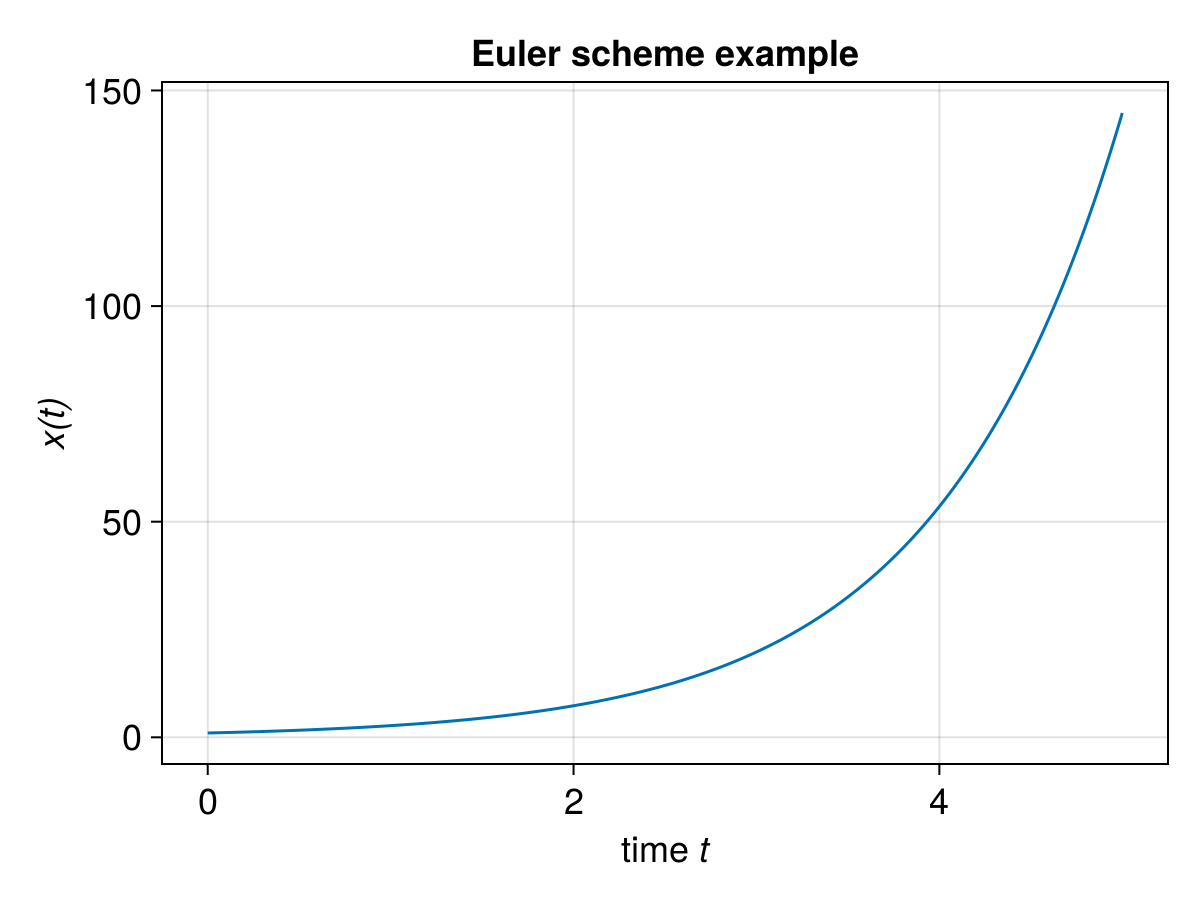

In [62]:
# plot
fig2 = Figure(fontsize = 18)
ax2 = Axis(
    fig2[1,1];
    xlabel = rich("time ", rich("t", font=:italic)),
    ylabel = rich("x(t)", font=:italic),
    title = "Euler scheme example",
)

lines!(ax2, tspan, sol_euler2)

fig2


### comparaison des temps d'exécution

In [70]:
@time begin     # begin ... end block : for @time to estimate the whole simulation length
    sol = [x0]  # initiate the solution as a vector

    for i in tspan[2:end]   # the component at tspan[1] = t0 is actually x0
        solnext = sol[end] + r * h * sol[end]   # compute next approx
        push!(sol, solnext)                     # push it into sol
    end
end


  0.000114 seconds (3.01 k allocations: 62.328 KiB)


In [74]:
@time begin
    sol2 = similar(tspan)   # create a vector of the same size (and type) as tspan

    sol2[1] = x0    # initial condition

    for i in eachindex(tspan[2:end])    # same as above, we know sol at t0
        sol2[i+1] = sol2[i] + r * h * sol2[i]
    end
end


  0.000140 seconds (2.50 k allocations: 51.016 KiB)


le *problème* est que Julia optimise tellement bien les choses que la version avec `push` est aussi rapide que la version avec pré-allocation du vecteur, les deux étant de l'ordre de grandeur de Python avec pré-allocation.

## version avec des fonctions

Nous montrons ici comment réaliser un code un peu plus générique:
- une fonction `my_euler` qui simule une EDO selon l'algorithme vu ci-dessus
- deux fonctions EDO tests : `mylinear()` et `mylogistic`

In [75]:
# EDO lineaire, arguments x et le parametre r
function mylinear(x, r)
    return r*x
end


mylinear (generic function with 1 method)

In [76]:
# EDO logistique, arguments x et les parametres r et K
function mylogistic(x, r, K)
    return r * x * (1 - x/K)
end


mylogistic (generic function with 1 method)

In [77]:
# integrateur de Euler
# arguments: x0, tspan, la fonction EDO myedo et ses paramètres p
function my_euler(x0, tspan, myedo, p)
    sol = similar(tspan)
    sol[1] = x0

    for i in eachindex(tspan[2:end])
        # p... éclate le vecteur de parametres dans les arguments de myedo()
        sol[i+1] = sol[i] + h * myedo(sol[i], p...)
    end
    return sol
end


my_euler (generic function with 1 method)

In [78]:
plinear = 1.0     # this is just r, could be a Vector, a Tuple or a named Tuple
my_euler(x0, tspan, mylinear, plinear)


501-element Vector{Float64}:
   1.0
   1.01
   1.0201
   1.030301
   1.0406040099999998
   1.0510100500999997
   1.0615201506009997
   1.0721353521070096
   1.0828567056280798
   1.0936852726843607
   ⋮
 133.69522641373104
 135.03217867786836
 136.38250046464705
 137.7463254692935
 139.12378872398645
 140.51502661122632
 141.92017687733858
 143.33937864611195
 144.77277243257308

In [79]:
plogistic = [1.0, 10.0]     # this is r and K
my_euler(x0, tspan, mylogistic, plogistic)


501-element Vector{Float64}:
 1.0
 1.009
 1.0180719189999998
 1.0272161677577434
 1.036433156380018
 1.0457232942561743
 1.055086989990586
 1.0645246513340443
 1.0740366851140868
 1.0836234971642569
 ⋮
 9.384855093527575
 9.390628139336341
 9.396350523878409
 9.402022625949604
 9.407644822750232
 9.413217489866716
 9.41874100125385
 9.424215729217687
 9.42964204439903

## en utilisant `DifferentialEquations.jl`

In [19]:
using DifferentialEquations


Comme tout package d'intégration il y a une interface spécifique pour utiliser les routines d'intégration.

Cela passe par une fonction définissant l'EDO, i.e. renvoyant la dérivée de l'état en fonction (dans cet ordre car ce sont des arguments positionnels):
- de l'état `u` (ils s'agit de l'état dans le jargon du package, ca pourrait être `x` directement)
- de paramètres `p`
- du temps `t`

In [80]:
function mylinear_diffeq(u, p, t)
    r = p       # on utilise les notations "naturelles"
    x = u

    dx = r * x
    return dx
end


mylinear_diffeq (generic function with 1 method)

L'horizon d'intégration `tspan` est défini sous la forme d'un tuple `(t0, tf)`


In [81]:
# tspan
tspan_diffeq = (t0, tf)


(0.0, 5.0)

On définit un problème d'intégration:

In [84]:
prob_linear = ODEProblem(
    mylinear_diffeq,    # l'EDO à intégrer
    x0,                 # la condition initiale
    tspan_diffeq,       # l'horizon d'intégration
    r,                  # le (vecteur) de paramètres de l'EDO
)


ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 1.0

In [85]:
sol_diffeq = solve(prob_linear)


retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 11-element Vector{Float64}:
 0.0
 0.10001999200479662
 0.3480203186480749
 0.6830525653177172
 1.088453603660044
 1.5745363386191944
 2.132828542670681
 2.761817348490008
 3.454773034680872
 4.206436466814058
 5.0
u: 11-element Vector{Float64}:
   1.0
   1.105193012902056
   1.4162610240705922
   1.9799122739515003
   2.969677774531698
   4.82849926047279
   8.438685921010583
  15.828504039542459
  31.650758886570518
  67.11551626768338
 148.40781164754134

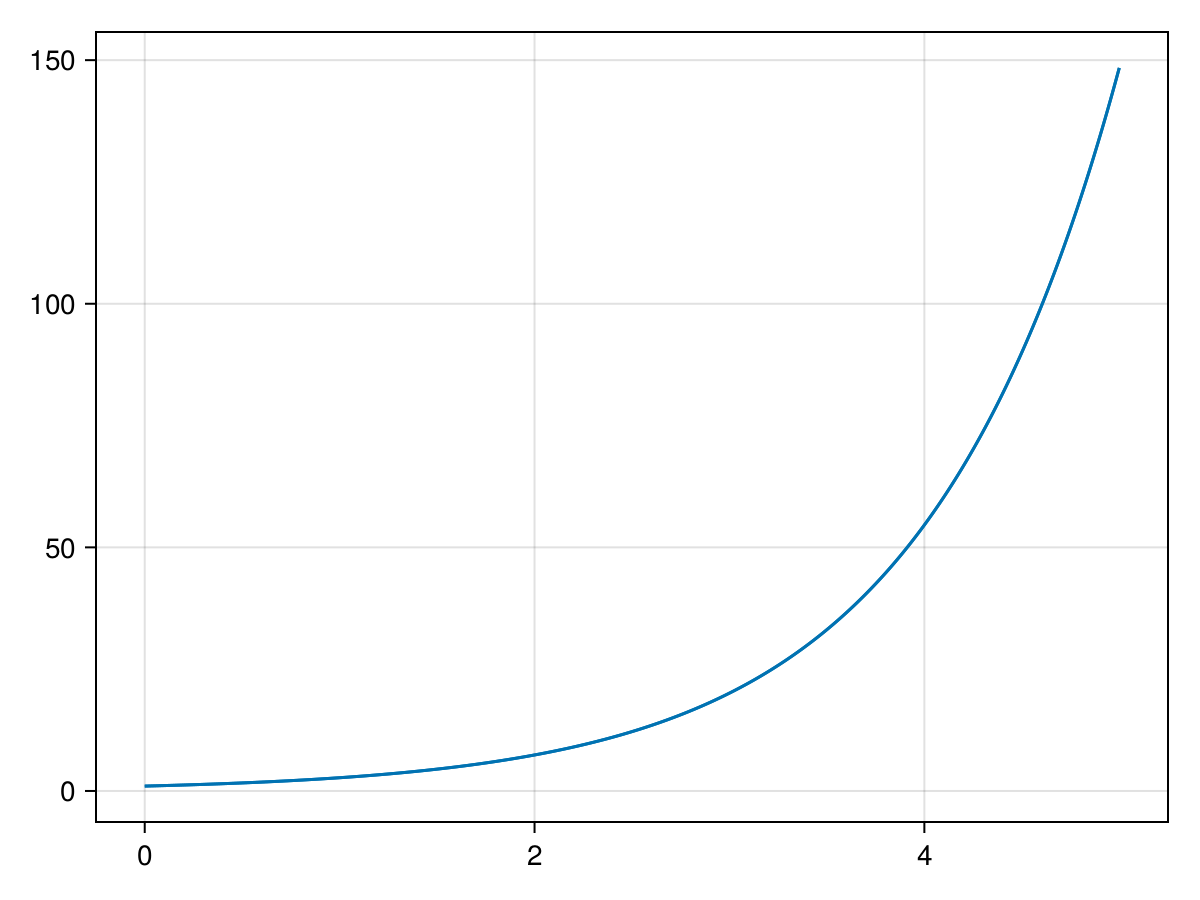

In [86]:
lines(sol_diffeq)



#### erreur de simulation

Pour une équation linéaire, nous connaissons la solution mathématique : 
$$
x(t) = e^{rt} x_0
$$
Nous pouvons comparer les résultats des simulations à cette solution en calculant l'erreur de simulation.

In [87]:
# fonction renvoyant la solution mathématique au temps t
sol_math(t) = exp(r*t)*x0


sol_math (generic function with 1 method)

L'algorithme d'Euler que nous avons programmé calcule un vecteur approximant la solution le long de l'horizon temporel `tspan`.

On peut facilement obtenir la même chose pour la solution mathématique avec une compréhension de liste:

In [89]:
sol_math_vec = [sol_math(t) for t in tspan]


501-element Vector{Float64}:
   1.0
   1.010050167084168
   1.0202013400267558
   1.030454533953517
   1.0408107741923882
   1.0512710963760241
   1.0618365465453596
   1.0725081812542165
   1.0832870676749586
   1.0941742837052104
   ⋮
 137.00261318646898
 138.3795123399606
 139.770249560003
 141.17496392147686
 142.5937958969891
 144.02688737091955
 145.47438165361004
 146.9364234956948
 148.4131591025766

L'objet `solution` renvoyé par `solve()` de `DifferentialEquations` est complexe. On peut accéder aux temps calculés automatiquement par le solveur via le champ `t`:

In [90]:
sol_diffeq.t


11-element Vector{Float64}:
 0.0
 0.10001999200479662
 0.3480203186480749
 0.6830525653177172
 1.088453603660044
 1.5745363386191944
 2.132828542670681
 2.761817348490008
 3.454773034680872
 4.206436466814058
 5.0

et à la solution selon ces temps via le champ `u` (rappel, `u` est l'état dans `DifferentialEquations.jl`):

In [91]:
sol_diffeq.u


11-element Vector{Float64}:
   1.0
   1.105193012902056
   1.4162610240705922
   1.9799122739515003
   2.969677774531698
   4.82849926047279
   8.438685921010583
  15.828504039542459
  31.650758886570518
  67.11551626768338
 148.40781164754134

Mais l'objet est lui-même aussi une fonction du temps, on peut donc calculer la solution le long de `tspan` par compréhension de liste:

In [92]:
sol_diffeq_vec = [sol_diffeq(t) for t in tspan]


501-element Vector{Float64}:
   1.0
   1.0100501674211133
   1.020201340870267
   1.0304545350241314
   1.0408107750899735
   1.0512710968056593
   1.0618365464396526
   1.0725081807910148
   1.0832870671894048
   1.0941742834950818
   ⋮
 136.9963619941851
 138.37346683587538
 139.7643948704786
 141.16927990473016
 142.58825672166742
 144.0214610806281
 145.46902971725032
 146.9311003434747
 148.40781164754077

Finalement nous pouvons calculer les erreurs d'approximation faites par le shema d'Euler et la routine d'intégration :

In [93]:
err_euler = sol_math_vec - sol_euler
err_diffeq = sol_math_vec - sol_diffeq_vec;     # ; permet de ne pas renvoyer le résultat


Et on peut représenter ces erreurs contre le temps:

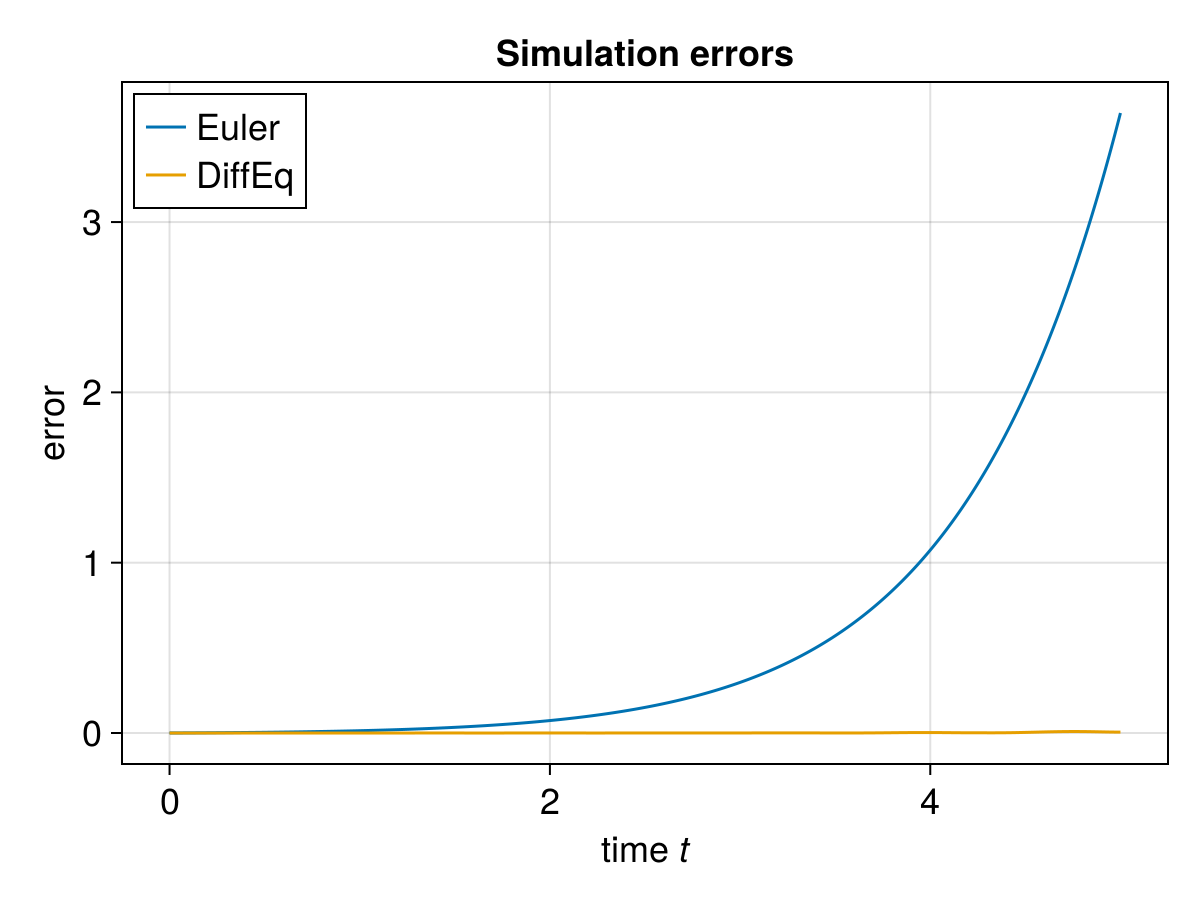

In [94]:
figerr = Figure(fontsize = 18)
axerr = Axis(
    figerr[1,1];
    xlabel = rich("time ", rich("t", font=:italic)),
    ylabel = rich("error"),
    title = "Simulation errors",
)

lines!(axerr, tspan, err_euler, label = "Euler")
lines!(axerr, tspan, err_diffeq, label = "DiffEq")

axislegend(axerr, position = :lt)

figerr


#### options du solveur

On peut passer de nombreuses options pour la simulation. Par exemple ici sur les tolérances, et le format de sortie de la simulation :


In [96]:
prob_linear2 = ODEProblem(
    mylinear_diffeq,    # l'EDO à intégrer
    x0,                 # la condition initiale
    tspan_diffeq,       # l'horizon d'intégration
    r;                  # le (vecteur) de paramètres de l'EDO
    reltol = 1e-6,      # modifie la tolérance relative
    abstol = 1e-6,      # modifie la tolérance absolue
    saveat = h,         # impose de sauver la solution/le temps tous les pas de temps h
)


ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 1.0

Par défaut, l'algorithme utilisé est un Runge-Kunta (Tsitouras 5/4 Runge-Kutta method, (free 4th order interpolant)), appelé `Tsit5`. Il est possible de modifier cet algorithme facilement, cf. la [documentation](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Recommended-Methods), avec un choix énorme qui vont de `Euler` à différents solveurs pour systèmes raides, et adaptatifs. 

Par exemple pour utiliser le même algortihme que la routine `ode45` de Matlab (Dormand-Prince's 5/4 Runge-Kutta method. (free 4th order interpolant)), il faut utiliser l'algorithme `DP5` (bien que semble-t-il `Tsit5` soit plus efficace):

In [97]:
solve(prob_linear2, DP5())


retcode: Success
Interpolation: 1st order linear
t: 501-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 4.92
 4.93
 4.94
 4.95
 4.96
 4.97
 4.98
 4.99
 5.0
u: 501-element Vector{Float64}:
   1.0
   1.0100501670899398
   1.0202013400292786
   1.0304545339779887
   1.040810775994059
   1.0512711013461695
   1.0618365545998865
   1.0725081914343866
   1.0832870786424575
   1.0941742941304982
   ⋮
 137.0027059882271
 138.37960618202445
 139.7703443850553
 141.1750596672059
 142.59389252345215
 144.02698487385922
 145.47448006358178
 146.93652286286343
 148.41325946703748